# Anomaly Detection 

This notebook attempts anomaly detection using the time series trend of traffic data. 

Current scope:
- Use only the total number of cars on the road
- Not taking into account:
    - Traffic direction 
    - Position of cars

Current progress
- Data preprocessing is complete 

## Packages

In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import matplotlib.gridspec as gridspec

## Constants

In [2]:
SEED=53456
CAMERA = '147'
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sample_period = '30min' #period to temporally aggregate the data
thresh_samples = 350 #minimum number of samples to consider a day

# setting up the paths
cwd=os.getcwd()
root = os.path.dirname(cwd)

# data paths
processed_image_dir = os.path.join(root, 'dat','processed_images')
image_folder = os.path.join(processed_image_dir,CAMERA,'2024-12-11')
output_folder = os.path.join(root, 'dat','output')
camera_dir = os.path.join(processed_image_dir, CAMERA)
tabular_csv_path = os.path.join(output_folder, 'traffic_oneway.csv')

# model paths
run_dir = os.path.join(root, 'runs','detect')
best_weights_path  = os.path.join(run_dir, 'train15', 'weights','best.pt')

## Functions

In [3]:
def fill_missing_values(row, df_avg_vals):
    if pd.isna(row['num_cars']):
        day, time = row['day'], row['time_of_day']
        return df_avg_vals.loc[day].loc[time].values[0]
    return row['num_cars']

## Loading data

In [4]:
df = pd.read_csv(tabular_csv_path)

## Preprocessing

Filtering samples
- Filtering outdays with sample below `thresh_samples` set in constants.

Plotting trends
- The samples at two minute level resolution is noisy. Therefore, temporal aggregation is required.
- Interpolation is required for some day above the `thresh_samples` due to missing values

Aggregating data
- The sample have been aggregated temporally at 30 minute intervals. 
- When plotting the trends are cleaner and can be used for modelling/anomaly detection.

Interpolating values 
- Average values have been calculated by grouping by day and time of day.
- Missing values and filled using the averages calculated above. 

<a id="filter_samples"></a>
### Filtering samples

In [5]:
df['time'] = pd.to_datetime(df['time'])
df.sort_values(by='time', inplace=True)
df['day_of_year'] = df['time'].dt.dayofyear + (df['time'].dt.year-2024)*365
series_n_samples = df['day_of_year'].value_counts()

valid_days = series_n_samples[series_n_samples>thresh_samples].index
mask = df.day_of_year.map(lambda x: x in valid_days)
df_filtered = df[mask].reset_index(drop=True)
df_filtered

,time,class,confidence,num_cars,incoming,outgoing,camera,day_of_year
0,2024-10-28 00:02:00,tensor([]),tensor([]),0.0,0.0,0.0,147,302
1,2024-10-28 00:04:00,tensor([]),tensor([]),0.0,0.0,0.0,147,302
2,2024-10-28 00:06:00,"tensor([1., 1.])","tensor([0.8188, 0.8117])",2.0,0.0,2.0,147,302
3,2024-10-28 00:08:00,tensor([]),tensor([]),0.0,0.0,0.0,147,302
4,2024-10-28 00:10:00,tensor([1.]),tensor([0.8646]),1.0,0.0,1.0,147,302
...,...,...,...,...,...,...,...,...
20491,2024-12-20 17:36:00,"tensor([1., 1., 0., 0., 1., 1., 0., 1., 0., 1....","tensor([0.9341, 0.9004, 0.8800, 0.8777, 0.8383...",26.0,16.0,10.0,147,355
20492,2024-12-20 17:38:00,"tensor([1., 1., 0., 1., 1., 1., 1., 1., 0., 0....","tensor([0.9364, 0.9194, 0.9161, 0.8802, 0.8643...",19.0,9.0,10.0,147,355
20493,2024-12-20 17:40:00,"tensor([0., 0., 0., 0.])","tensor([0.6407, 0.4934, 0.3998, 0.2756])",4.0,4.0,0.0,147,355
20494,2024-12-20 17:42:00,"tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0....","tensor([0.9290, 0.8444, 0.8380, 0.8104, 0.8094...",13.0,12.0,1.0,147,355


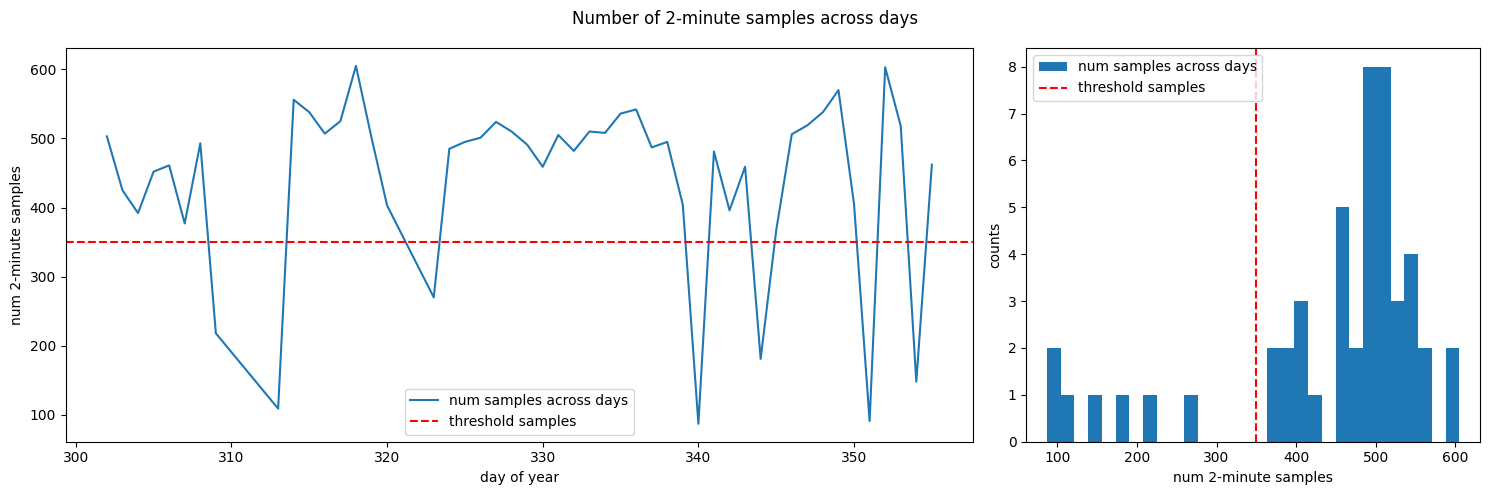

In [6]:
figure_size = (15, 5)

fig = plt.figure(figsize=figure_size)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # Adjust the width ratios

# Line plot
ax0 = plt.subplot(gs[0])


series_n_samples.sort_index().plot(kind='line', ax=ax0, label='num samples across days')
ax0.axhline(y=thresh_samples, color='r', linestyle='--', label='threshold samples')
ax0.set_xlabel('day of year')
ax0.set_ylabel('num 2-minute samples')
ax0.legend()

# Histogram
ax1 = plt.subplot(gs[1])
series_n_samples.plot(kind='hist', ax=ax1, bins=30, label='num samples across days')
ax1.axvline(x=thresh_samples, color='r', linestyle='--', label='threshold samples')
ax1.set_xlabel('num 2-minute samples')
ax1.set_ylabel('counts')
ax1.legend()

plt.suptitle('Number of 2-minute samples across days')
plt.tight_layout()
plt.show()

### Plotting trends

In [7]:
filter_date = lambda start_date, end_date: df_filtered.query(f"time >= '{start_date}' and time <= '{end_date}'")

def plot_days(start_date, end_date, figure_size=figure_size):
    df_plot = filter_date(start_date, end_date)
    plt.figure(figsize=figure_size)
    plt.plot(df_plot['time'], df_plot['num_cars'])
    plt.xlabel('time')
    plt.ylabel('num cars')
    plt.xticks(rotation=45)
    plt.show()


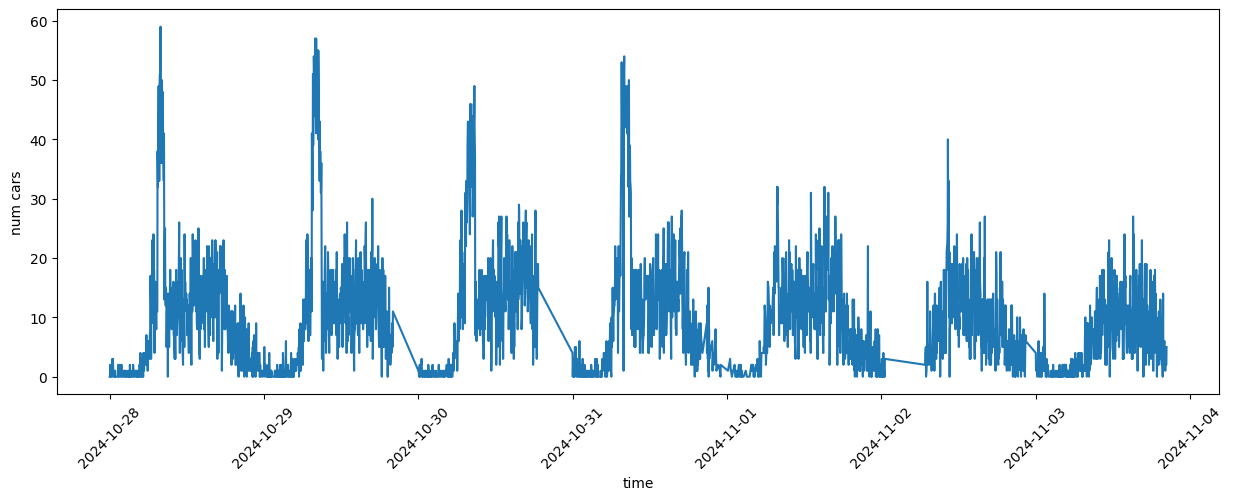

In [8]:
start_date = "2024-10-28"
end_date = "2024-11-04"
plot_days(start_date, end_date)

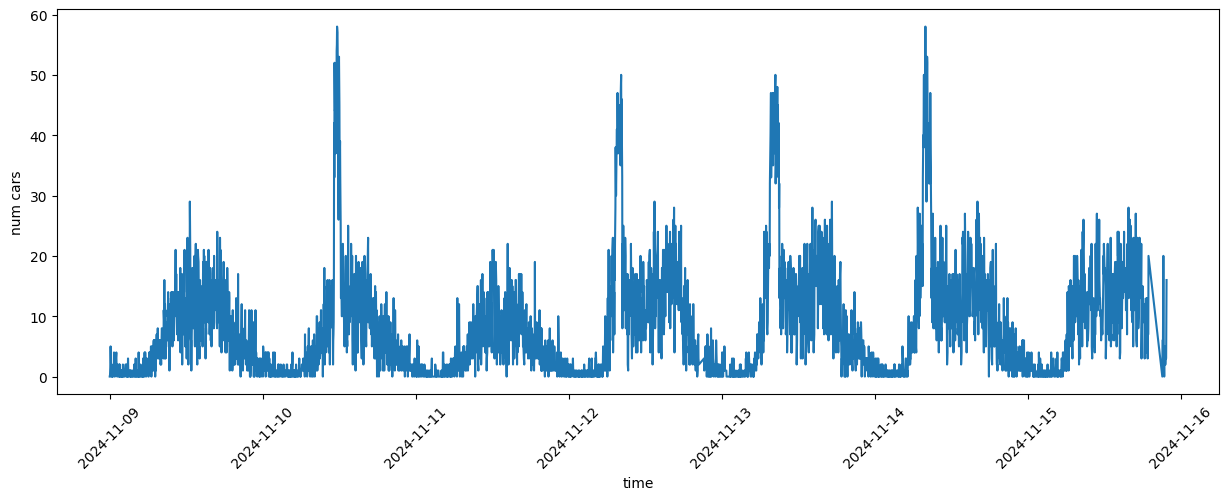

In [9]:
start_date = "2024-11-05"
end_date = "2024-11-16"
plot_days(start_date, end_date)

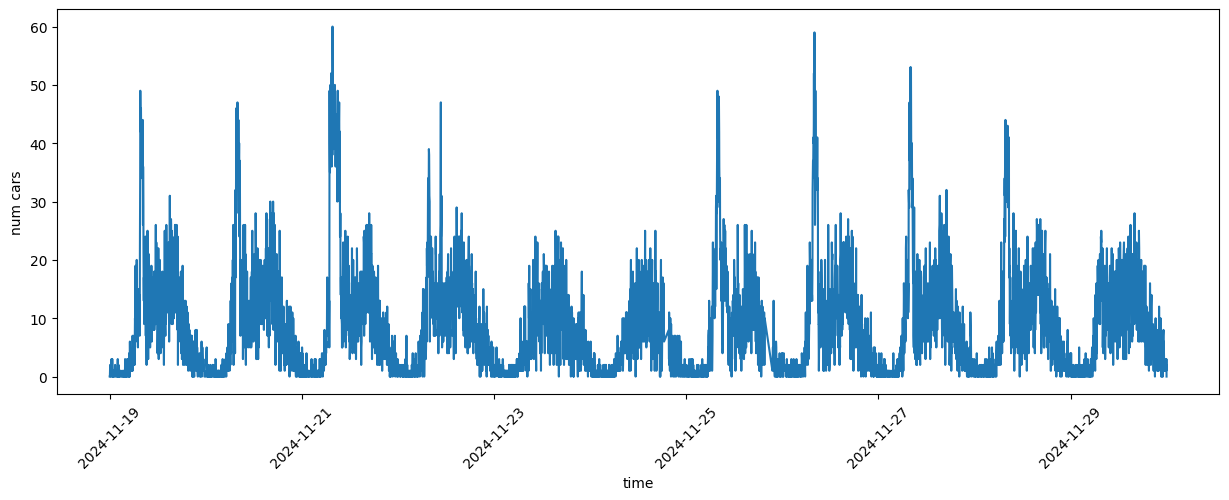

In [10]:
start_date = "2024-11-16"
end_date = "2024-11-30"
plot_days(start_date, end_date)

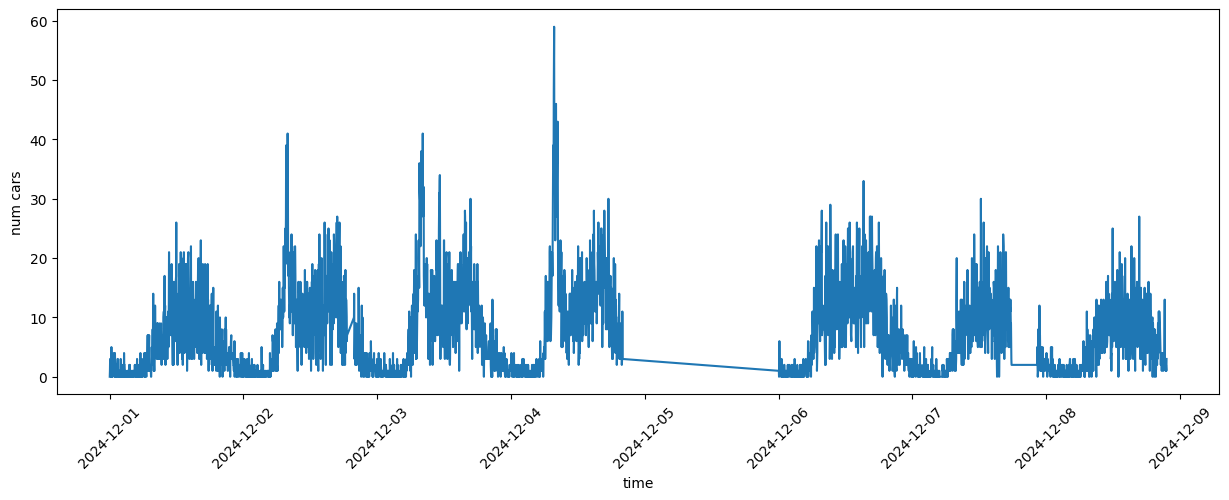

In [11]:
start_date = "2024-12-1"
end_date = "2024-12-9"
plot_days(start_date, end_date)

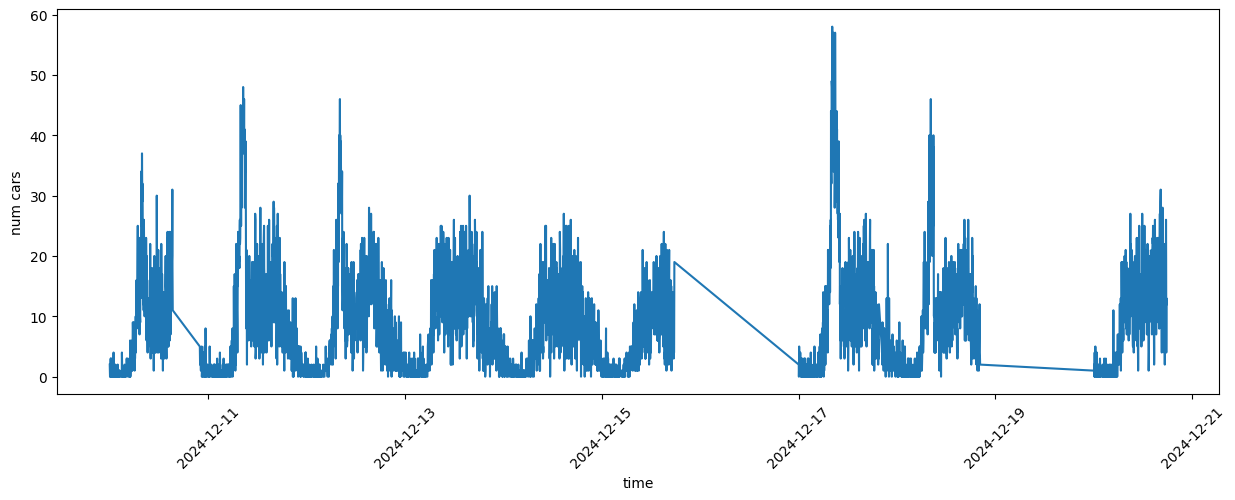

In [12]:
start_date = "2024-12-9"
end_date = "2024-12-21"
plot_days(start_date, end_date)

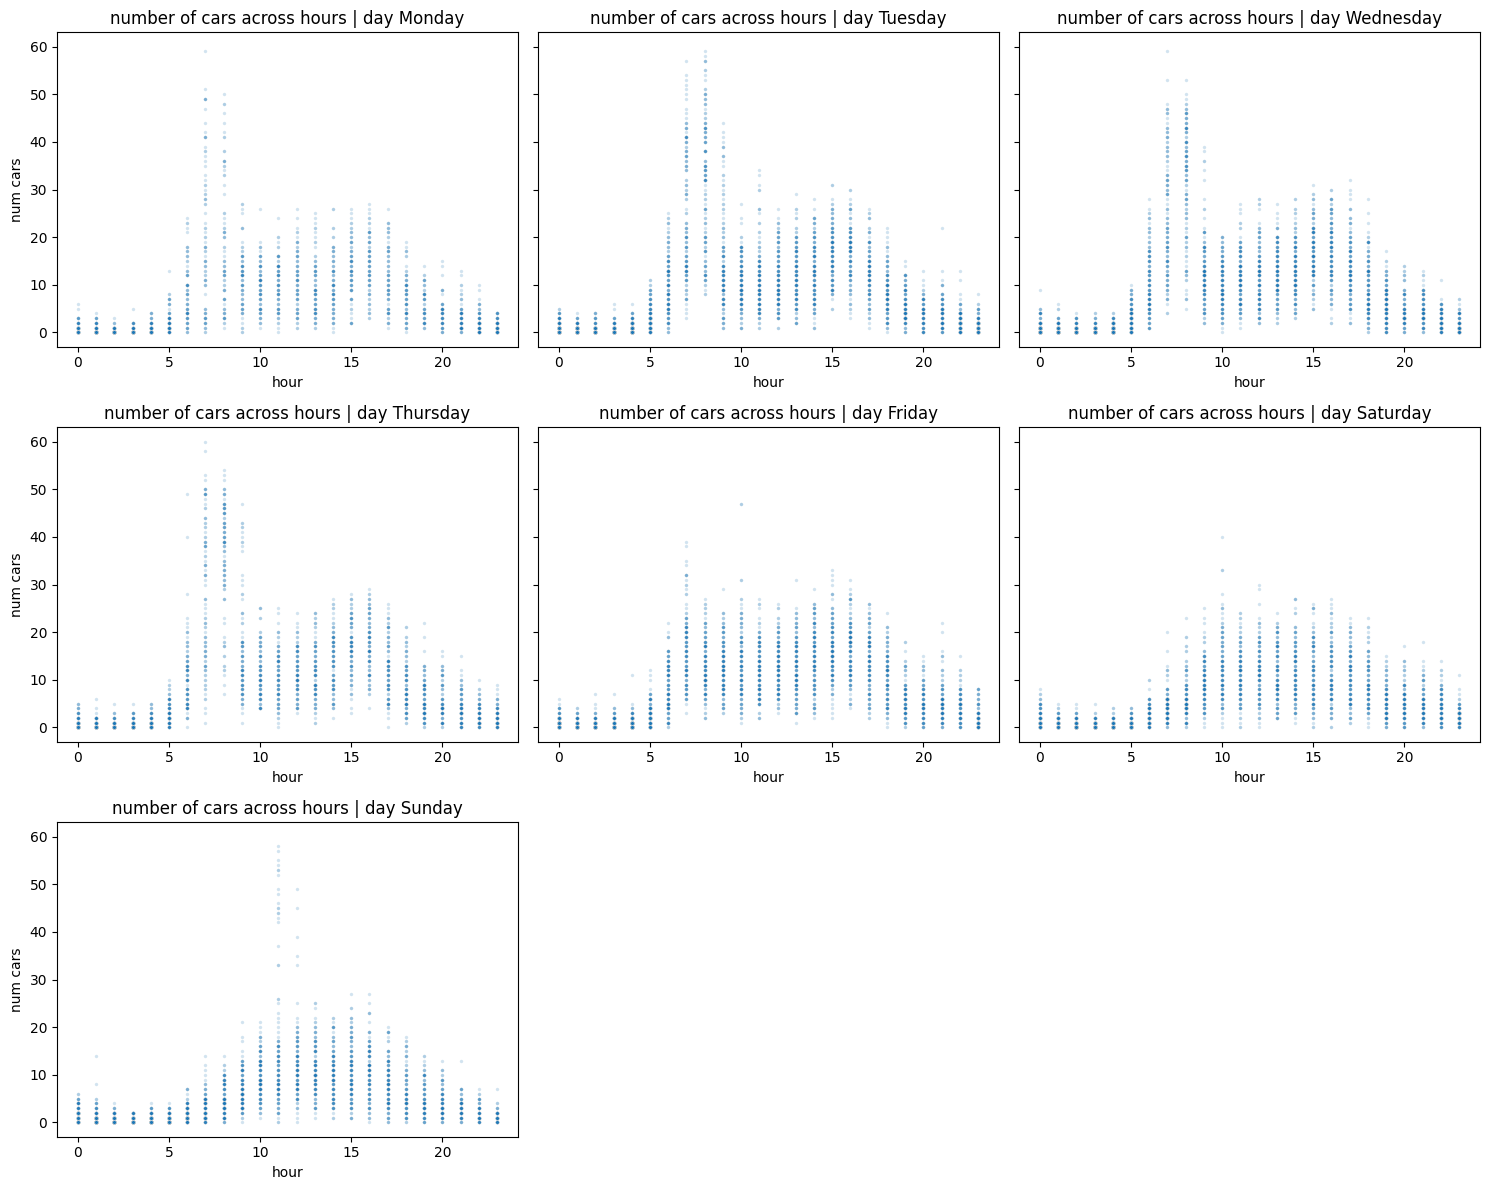

In [82]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=False, sharey=True)

axes = axes.flatten()
for i, day in enumerate(range(7)):
    ax = axes[day]
    sns.scatterplot(data=df_filtered.query(f"day == {day}"), x='hour', y='num_cars', s=6, alpha=0.2, ax=ax)
    ax.set_xlabel('hour')
    ax.set_ylabel('num cars')
    ax.set_title(f'number of cars across hours | day {days[day]}')

# Remove the unused axis
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Temporal aggregation 

In [35]:
# Aggregating the data temporally 
df_agg = df_filtered.copy()
df_agg.set_index('time', inplace=True)
df_agg = df_agg[['num_cars', 'incoming', 'outgoing']].resample(sample_period).mean()

# Recomputing columns resampled dataframe
df_agg['day_of_year']=df_agg.index.map(lambda x: x.day_of_year).values
df_agg['day']=df_agg.index.map(lambda x: x.day_of_week).values
df_agg['time_of_day'] = df_agg.index.time
get_30min = lambda x: (x.hour*60 + x.minute)//30
df_agg['30min']=df_agg['time_of_day'].apply(get_30min)

# Remove days with no samples
series_day_cars = df_agg.groupby('day_of_year')['num_cars'].count()
filter_days = series_day_cars[series_day_cars==0]
df_agg = df_agg[~df_agg['day_of_year'].map(lambda x: x in filter_days.index)]

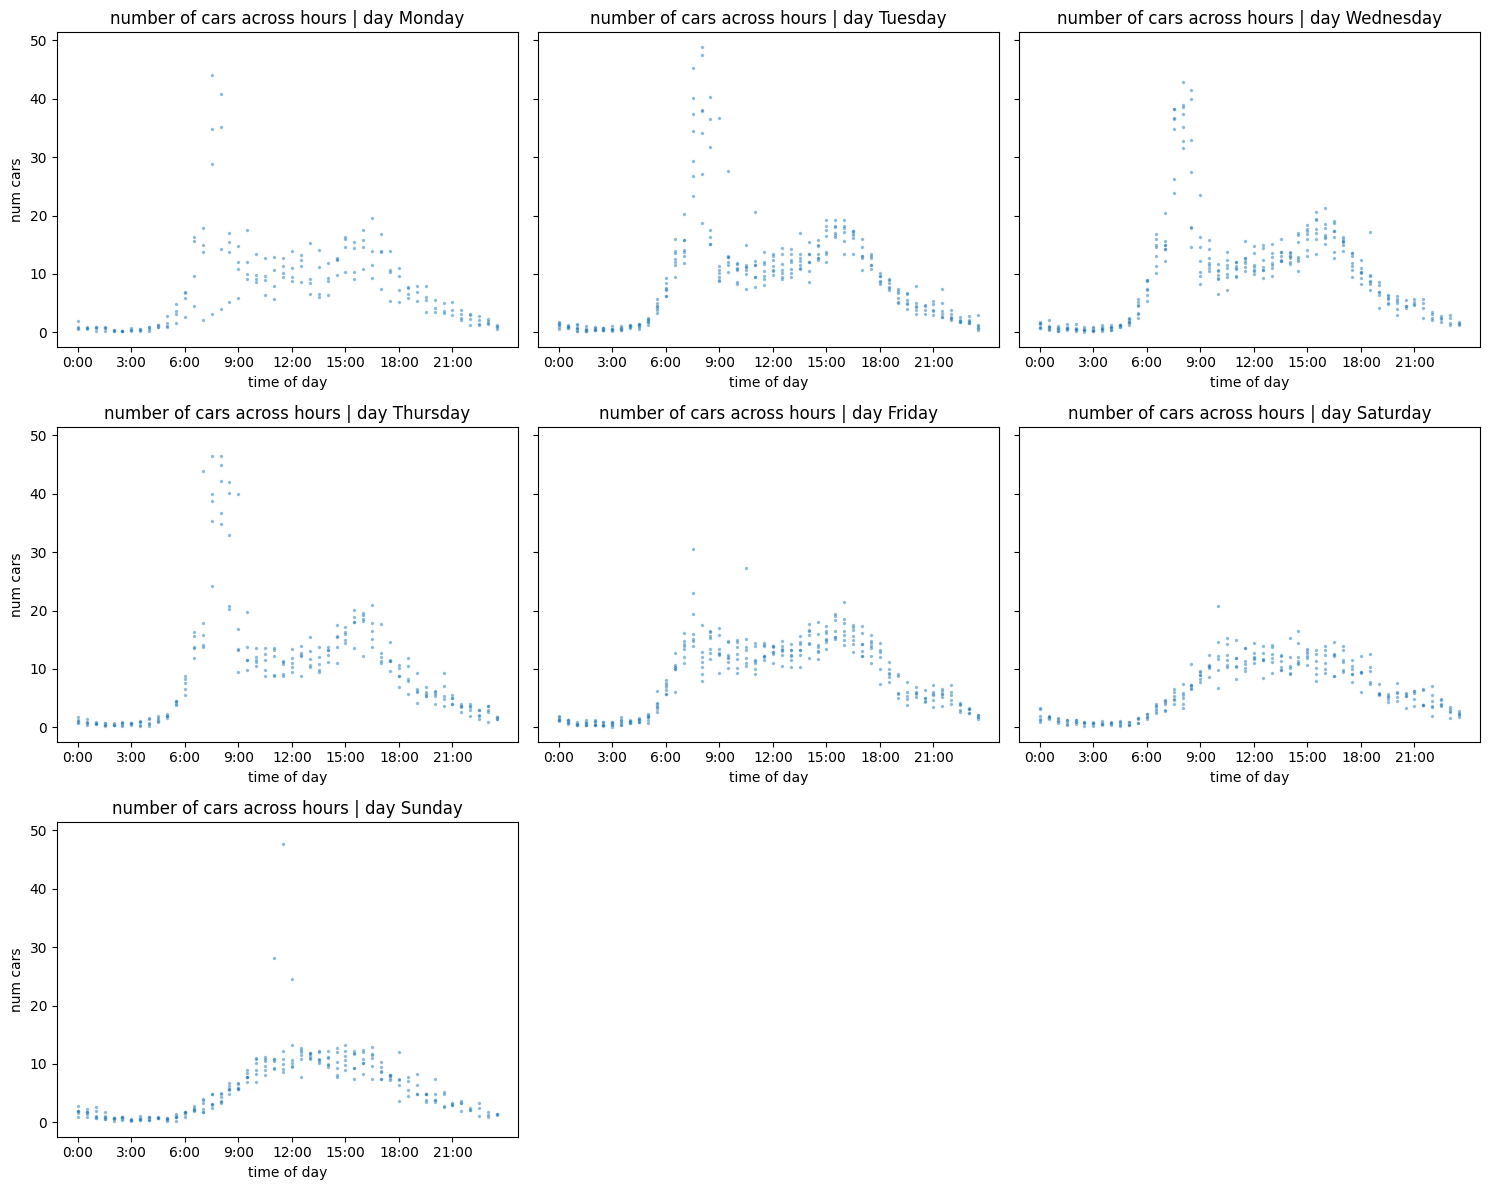

In [69]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=False, sharey=True)
x_loc = np.arange(0, 48, 6)
x_labels = [f'{i//2}:00' if i%2==0 else f'{i//2}:30' for i in x_loc]

axes = axes.flatten()
for i, day in enumerate(range(7)):
    ax = axes[day]
    sns.scatterplot(data=df_agg.query(f"day == {day}"), x='30min', y='num_cars', s=6, alpha=0.5, ax=ax)
    ax.set_xticks(x_loc, x_labels, rotation=0)
    ax.set_xlabel('time of day')
    ax.set_ylabel('num cars')
    ax.set_title(f'number of cars across hours | day {days[day]}')

# Remove the unused axis
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Histogram of num cars')

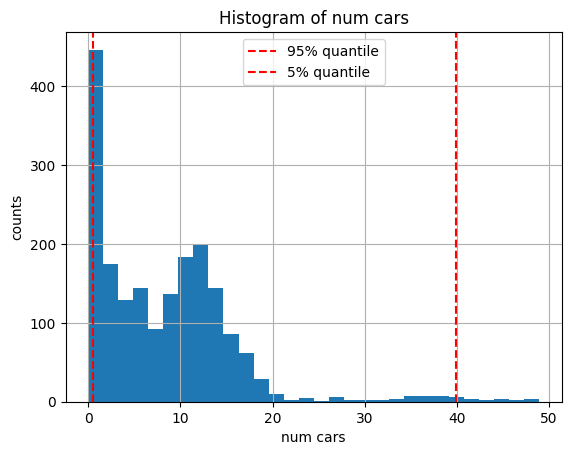

In [70]:
df_agg['num_cars'].hist(bins=30)
vmax = df_agg['num_cars'].quantile(0.99)
vmin = df_agg['num_cars'].quantile(0.05)

plt.axvline(x=vmax, color='r', linestyle='--', label='95% quantile')
plt.axvline(x=vmin, color='r', linestyle='--', label='5% quantile')
plt.xlabel('num cars')
plt.ylabel('counts')
plt.legend()
plt.title('Histogram of num cars')

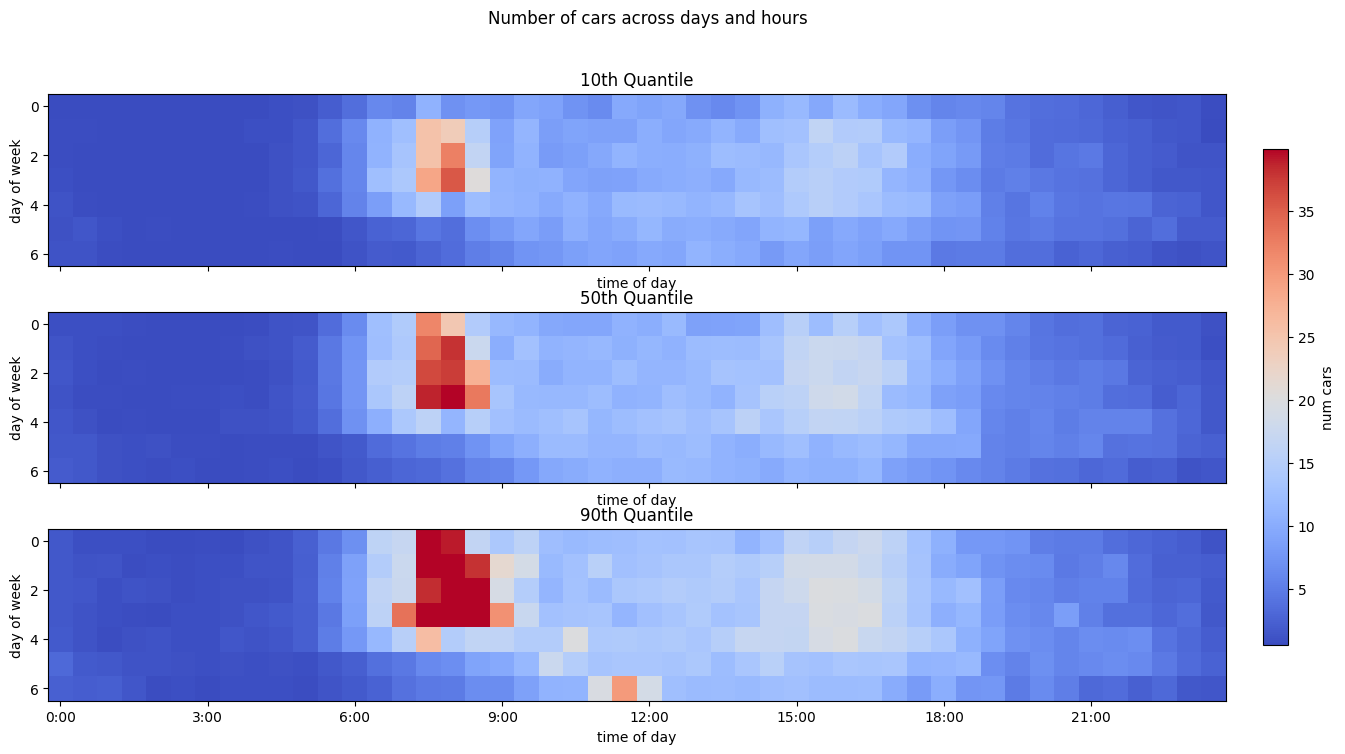

In [112]:

fig, axes = plt.subplots(3, 1, figsize=(16, 8), sharex=True, sharey=True)

quantiles = [0.10, 0.50, 0.90]
titles = ['10th Quantile', '50th Quantile', '90th Quantile']

plt.suptitle('Number of cars across days and hours')

for ax, quantile, title in zip(axes, quantiles, titles):
    matrix = df_agg.groupby(['time_of_day', 'day'])['num_cars'].quantile(quantile).unstack()
    im = ax.imshow(matrix.values.T, cmap='coolwarm', vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_ylabel('day of week')
    ax.set_xlabel('time of day')
    ax.set_xticks(x_loc)
    ax.set_xticklabels(x_labels, rotation=0)

#fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
fig.colorbar(im, ax=axes, label='num cars',fraction=0.02, pad=0.03)
plt.show()

### Interpolating values 

In [114]:
df_avg_vals = df_agg.groupby(['day','time_of_day'])[['num_cars']].mean()
df_agg['filled_num_cars']=df_agg.apply(fill_missing_values, axis=1, df_avg_vals=df_avg_vals)

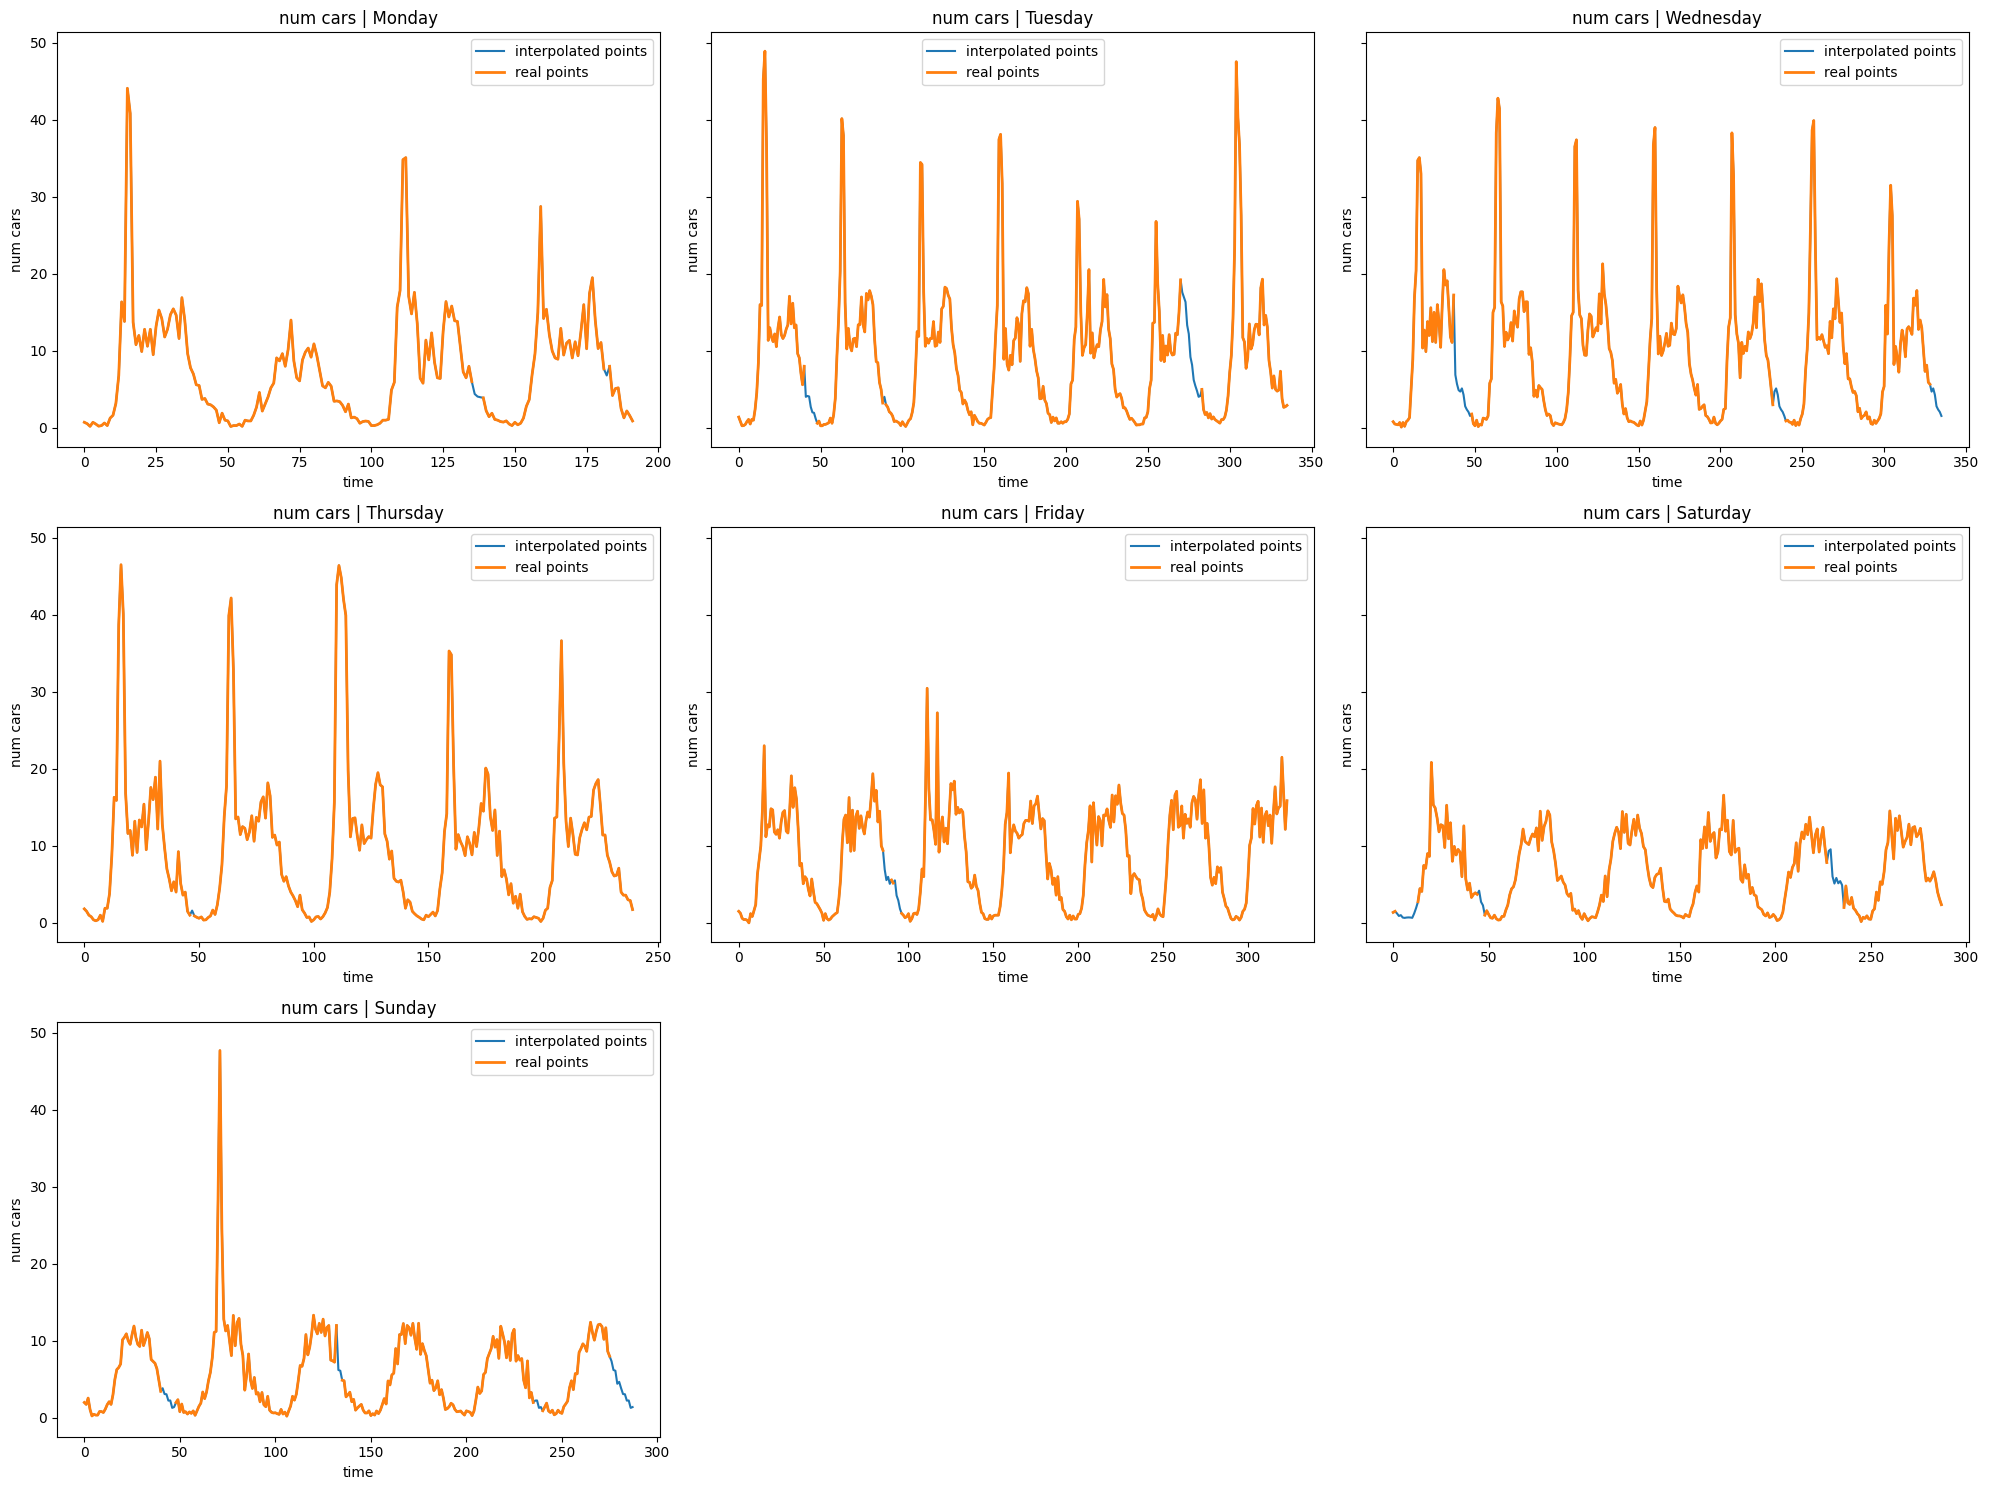

In [116]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15), sharex=False, sharey=True)
axes = axes.flatten()
for i, day in enumerate(range(7)):
    ax = axes[i]
    df_plot = df_agg.query(f"day == {day}")
    ax.plot(np.arange(len(df_plot)),df_plot['filled_num_cars'], label='interpolated points')
    ax.plot(np.arange(len(df_plot)),df_plot['num_cars'], label='real points', lw=2)
    ax.set_title(f'num cars | {days[day]}')
    ax.set_xlabel('time')
    ax.set_ylabel('num cars')
    ax.legend()

# Remove the unused axis
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()